# Count rain days (dry/moist/wet) in May, in a specified region, for given regional models

This notebook counts the number of dry/moist/wet days on a specified point in SGP. I then produces some interesting bar graphs.

* this version loads netcdf files directly via xarray
* "Gridmet data" can now be replaced with any model's output

### TODO items

* better graphs (i.e. include lat/lon scale)



In [1]:
from IPython import display
import numpy as np

#from skimage.metrics import structural_similarity as ssim
import copy


In [2]:
# load netcdf files directly via xarray
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy


# Configuration

In [3]:
# Ordering: nRow ordering: obs, raw, RegCM4, WRF, MPAS, CNN, SDSM, KDDM, MBCn, LOCA
mpi_sigfiles=['/glade/work/mcginnis/DCA/data/gen/final/gridmet/hist/prec.hist.gridMET.obs.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/mpi/hist/prec.hist.MPI-ESM-LR.raw.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/mpi/rcp85/prec.rcp85.MPI-ESM-LR.raw.day.2075-2100.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/regcm4/hist/prec.hist.MPI-ESM-LR.RegCM4.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/regcm4/rcp85/prec.rcp85.MPI-ESM-LR.RegCM4.day.2075-2100.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/wrf/hist/prec.hist.MPI-ESM-LR.WRF.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/wrf/rcp85/prec.rcp85.MPI-ESM-LR.WRF.day.2075-2100.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/mpas/hist/prec.hist.MPI-ESM-LR.MPAS.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/mpas/rcp85/prec.rcp85.MPI-ESM-LR.MPAS.day.2075-2100.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/cnn/hist/prec.hist.MPI-ESM-LR.CNN.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/cnn/rcp85/prec.rcp85.MPI-ESM-LR.CNN.day.2075-2100.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/sdsm/hist/prec.hist.MPI-ESM-LR.SDSM.day.1976-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/sdsm/rcp85/prec.rcp85.MPI-ESM-LR.SDSM.day.2070-2099.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/kddm/hist/prec.hist.MPI-ESM-LR.KDDM.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/kddm/rcp85/prec.rcp85.MPI-ESM-LR.KDDM.day.2075-2100.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/mbcn/hist/prec.hist.MPI-ESM-LR.MBCn.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/mbcn/rcp85/prec.rcp85.MPI-ESM-LR.MBCn.day.2075-2100.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/loca/hist/prec.hist.MPI-ESM-LR.LOCA.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/loca/rcp85/prec.rcp85.MPI-ESM-LR.LOCA.day.2075-2100.NAM-22i.SGP.x098.y36.nc']

# Compact Configuration

In [4]:
sigdir = '/glade/work/mcginnis/DCA/data/gen/final'
def model2absfilepath(mn, exp, x, y):
    if mn == 'obs' or mn == 'gridMET':
        mn = 'gridMET'
        filename = 'prec.{}.gridMET.{}.day.1980-2005.NAM-22i.SGP.x0{}.y{}.nc'.format(exp, 'obs', x, y)
    elif mn == 'raw' or mn == 'mpi':
        mn = 'mpi'
        if exp == 'hist':
            filename = 'prec.{}.MPI-ESM-LR.{}.day.1980-2005.NAM-22i.SGP.x0{}.y{}.nc'.format(exp, 'raw', x, y)
        elif exp == 'rcp85':
            filename = 'prec.{}.MPI-ESM-LR.{}.day.2075-2100.NAM-22i.SGP.x0{}.y{}.nc'.format(exp, 'raw', x, y)
        else: print("Unknown experiment!")
    elif mn == 'SDSM':  # starts at 1976
        if exp == 'hist':
            filename = 'prec.{}.MPI-ESM-LR.{}.day.1976-2005.NAM-22i.SGP.x0{}.y{}.nc'.format(exp, mn, x, y)
        elif exp == 'rcp85':
            filename = 'prec.{}.MPI-ESM-LR.{}.day.2070-2099.NAM-22i.SGP.x0{}.y{}.nc'.format(exp, mn, x, y)
        else: print("Unknown experiment!")

    elif exp == 'hist':
        filename = 'prec.{}.MPI-ESM-LR.{}.day.1980-2005.NAM-22i.SGP.x0{}.y{}.nc'.format(exp, mn, x, y)
    elif exp == 'rcp85':
        filename = 'prec.{}.MPI-ESM-LR.{}.day.2075-2100.NAM-22i.SGP.x0{}.y{}.nc'.format(exp, mn, x, y)
    else: print("Unknown experiment!")
    return sigdir + '/' + mn.lower() + '/' + exp + '/' + filename
    

In [5]:
# test single file
model2absfilepath('RegCM4', 'rcp85', 98, 36)

'/glade/work/mcginnis/DCA/data/gen/final/regcm4/rcp85/prec.rcp85.MPI-ESM-LR.RegCM4.day.2075-2100.NAM-22i.SGP.x098.y36.nc'

In [6]:
# create list of abs filepaths
[model2absfilepath(ff, 'hist', 98, 36) for ff in ['obs','raw','RegCM4','WRF','MPAS','CNN','SDSM','KDDM','MBCn','LOCA']]


['/glade/work/mcginnis/DCA/data/gen/final/gridmet/hist/prec.hist.gridMET.obs.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
 '/glade/work/mcginnis/DCA/data/gen/final/mpi/hist/prec.hist.MPI-ESM-LR.raw.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
 '/glade/work/mcginnis/DCA/data/gen/final/regcm4/hist/prec.hist.MPI-ESM-LR.RegCM4.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
 '/glade/work/mcginnis/DCA/data/gen/final/wrf/hist/prec.hist.MPI-ESM-LR.WRF.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
 '/glade/work/mcginnis/DCA/data/gen/final/mpas/hist/prec.hist.MPI-ESM-LR.MPAS.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
 '/glade/work/mcginnis/DCA/data/gen/final/cnn/hist/prec.hist.MPI-ESM-LR.CNN.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
 '/glade/work/mcginnis/DCA/data/gen/final/sdsm/hist/prec.hist.MPI-ESM-LR.SDSM.day.1976-2005.NAM-22i.SGP.x098.y36.nc',
 '/glade/work/mcginnis/DCA/data/gen/final/kddm/hist/prec.hist.MPI-ESM-LR.KDDM.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
 '/glade/work/mcginnis/DCA/data/gen/final/mbcn/hist/prec.hi

### Load model output data

In [7]:
##################
## LOAD GRIDMET ##
##################
# 1980-1989
istart = 365
#ndays = 3653  # 1980-1989
ndays = 13515 # 1980-2016 

dv1 = xr.open_dataset('/glade/work/dkorytin/srgan_data/prec128_gridmetA_1979-2016.nc')['prec'][istart:istart+ndays]
# dv2 = xr.open_dataset('/glade/work/dkorytin/srgan_data/tmax128_gridmetA_1979-2016.nc')['tmax'][istart:istart+ndays]
# dv3 = xr.open_dataset('/glade/work/dkorytin/srgan_data/tmin128_gridmetA_1979-2016.nc')['tmin'][istart:istart+ndays]
# dv4 = xr.open_dataset('/glade/work/dkorytin/srgan_data/uas128_gridmetA_1979-2016.nc')['uas'][istart:istart+ndays]
# dv5 = xr.open_dataset('/glade/work/dkorytin/srgan_data/vas128_gridmetA_1979-2016.nc')['vas'][istart:istart+ndays]
# dv6 = xr.open_dataset('/glade/work/dkorytin/srgan_data/huss128_gridmetA_1979-2016.nc')['huss'][istart:istart+ndays]
# dv7 = xr.open_dataset('/glade/work/dkorytin/srgan_data/rsds128_gridmetA_1979-2016.nc')['rsds'][istart:istart+ndays]
# dv8 = xr.open_dataset('/glade/work/dkorytin/srgan_data/miss128_gridmetB_1979-2016.nc')['miss'][istart:istart+ndays]




### Load MPI UATM data

In [8]:
###########################
## LOAD ERAI data: daily ##
###########################
def load_uatm_erai():
    global mdv1,mdv2,mdv3,mdv4,mdv5,mdv6,mdv7,mdv8,mnvars
    
    # load eraionmpi
    #mndays = 11688      # 1979-2010
    mstart = 365
    mndays = 13515       # 1980-2016 
    mnvars = 8*1
    mdv1 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/U850.ERAI.MPIGRID.1979-2018.nc')['U'][mstart:mstart+mndays*1]
    mdv2 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/V850.ERAI.MPIGRID.1979-2018.nc')['V'][mstart:mstart+mndays*1]
    mdv3 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/Q850.ERAI.MPIGRID.1979-2018.nc')['Q'][mstart:mstart+mndays*1]
    mdv4 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/T700.ERAI.MPIGRID.1979-2018.nc')['T'][mstart:mstart+mndays*1]
    mdv5 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/Z700.ERAI.MPIGRID.1979-2018.nc')['Z'][mstart:mstart+mndays*1]
    mdv6 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/Z500.ERAI.MPIGRID.1979-2018.nc')['Z'][mstart:mstart+mndays*1]
    mdv7 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/U250.ERAI.MPIGRID.1979-2018.nc')['U'][mstart:mstart+mndays*1]
    mdv8 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/V250.ERAI.MPIGRID.1979-2018.nc')['V'][mstart:mstart+mndays*1]

    print("Days loaded", len(mdv7))


In [9]:
###################
## LOAD MPI      ##
###################  
def load_uatm_mpi_hist():
    global mdv1,mdv2,mdv3,mdv4,mdv5,mdv6,mdv7,mdv8,mnvars
    
    mnvars = 8
    
    d='/glade/p/ral/risc/rmccrary/CMIP5_CORDEX/NAmerica/MPI-ESM-LR/native/historical/'

    mdv1 = xr.open_dataset(d+'U_MPI-ESM-LR_historical_r1i1p1_NAmerica_p850_19500101-20051231_dayavg_mpigrid.nc')['U'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv2 = xr.open_dataset(d+'V_MPI-ESM-LR_historical_r1i1p1_NAmerica_p850_19500101-20051231_dayavg_mpigrid.nc')['V'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv3 = xr.open_dataset(d+'Q_MPI-ESM-LR_historical_r1i1p1_NAmerica_p850_19500101-20051231_dayavg_mpigrid.nc')['Q'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv4 = xr.open_dataset(d+'T_MPI-ESM-LR_historical_r1i1p1_NAmerica_p700_19500101-20051231_dayavg_mpigrid.nc')['T'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv5 = xr.open_dataset(d+'Z_MPI-ESM-LR_historical_r1i1p1_NAmerica_p700_19500101-20051231_dayavg_mpigrid.nc')['Z'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv6 = xr.open_dataset(d+'Z_MPI-ESM-LR_historical_r1i1p1_NAmerica_p500_19500101-20051231_dayavg_mpigrid.nc')['Z'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv7 = xr.open_dataset(d+'U_MPI-ESM-LR_historical_r1i1p1_NAmerica_p250_19500101-20051231_dayavg_mpigrid.nc')['U'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv8 = xr.open_dataset(d+'V_MPI-ESM-LR_historical_r1i1p1_NAmerica_p250_19500101-20051231_dayavg_mpigrid.nc')['V'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))

def load_uatm_mpi_future():
    global mdv1,mdv2,mdv3,mdv4,mdv5,mdv6,mdv7,mdv8,mnvars
    
    d='/glade/p/ral/risc/rmccrary/CMIP5_CORDEX/NAmerica/MPI-ESM-LR/native/rcp85/'

    mnvars = 8
    mdv1 = xr.open_dataset(d+'U_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p850_20060101-21001231_dayavg_mpigrid.nc')['U'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv2 = xr.open_dataset(d+'V_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p850_20060101-21001231_dayavg_mpigrid.nc')['V'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv3 = xr.open_dataset(d+'Q_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p850_20060101-21001231_dayavg_mpigrid.nc')['Q'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv4 = xr.open_dataset(d+'T_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p700_20060101-21001231_dayavg_mpigrid.nc')['T'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv5 = xr.open_dataset(d+'Z_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p700_20060101-21001231_dayavg_mpigrid.nc')['Z'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv6 = xr.open_dataset(d+'Z_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p500_20060101-21001231_dayavg_mpigrid.nc')['Z'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv7 = xr.open_dataset(d+'U_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p250_20060101-21001231_dayavg_mpigrid.nc')['U'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv8 = xr.open_dataset(d+'V_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p250_20060101-21001231_dayavg_mpigrid.nc')['V'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))

#load_uatm_mpi_future()


# Averaging code

In [31]:
###################
## UATM averages ##
###################

def calc_uatm_average(mpr_min, mpr_max, rainsignal, ymin, ymax):
    # global inputs: dv[1-8], mdv[1-8], mnvars
    mnvars = 8
    
    # initialize accumulators
    indices = []
    distribution = []
    raw_ires = len(mdv1[0])
    raininput = np.zeros((mnvars, raw_ires, raw_ires))
    raincount = 0
    
    for ii in range(0,len(rainsignal)):
        mpr = rainsignal[ii]
            
        # May = 5
        if mpr["time.month"] == 5 and mpr["time.year"] >= ymin and mpr["time.year"] <= ymax:    



            if mpr >= mpr_min and mpr < mpr_max:
                distribution.append(mpr)
                indices.append(ii)

                #mpr = dv1[ii].sel(lat=slice(32.125,38.125), lon=slice(-101.875,-93.875)).mean()

                # find matching input sample 
                #ot= dv1[ii-1]['time']
                ot = str(np.array(mpr['time']))

                mdv1.sel(time=ot,method='nearest')
                isample = [mdv1.sel(time=ot,method='nearest'),mdv2.sel(time=ot,method='nearest'),mdv3.sel(time=ot,method='nearest'),mdv4.sel(time=ot,method='nearest'),mdv5.sel(time=ot,method='nearest'),mdv6.sel(time=ot,method='nearest'),mdv7.sel(time=ot,method='nearest'),mdv8.sel(time=ot,method='nearest')]
                #ot= dv1[ii]['time']
                #assert ot["time.day"]==isample[0]['time.day'], "Days are not equal"
                isample = np.array(isample)

                raininput += isample
                raincount += 1
            
    raininput /= raincount
    #print("days:", raincount)
    
    return raininput, raincount, distribution, indices


def calc_rain_days(mpr_min, mpr_max, rainsignal, ymin, ymax):
    # same as calc_uatm_average(), but without UATM averages
    
    # initialize accumulators
    raincount = 0
    
    for ii in range(0,len(rainsignal)):
        mpr = rainsignal[ii]
            
        # May = 5
        if mpr["time.month"] == 5 and mpr["time.year"] >= ymin and mpr["time.year"] <= ymax:    


            if mpr >= mpr_min and mpr < mpr_max:
 
                #mpr = dv1[ii].sel(lat=slice(32.125,38.125), lon=slice(-101.875,-93.875)).mean()

                # find matching input sample 
                #ot= dv1[ii-1]['time']
                ot = str(np.array(mpr['time']))

                mdv1.sel(time=ot,method='nearest')
                isample = [mdv1.sel(time=ot,method='nearest'),mdv2.sel(time=ot,method='nearest'),mdv3.sel(time=ot,method='nearest'),mdv4.sel(time=ot,method='nearest'),mdv5.sel(time=ot,method='nearest'),mdv6.sel(time=ot,method='nearest'),mdv7.sel(time=ot,method='nearest'),mdv8.sel(time=ot,method='nearest')]
                #ot= dv1[ii]['time']
                #assert ot["time.day"]==isample[0]['time.day'], "Days are not equal"

                raincount += 1
            
    
    return raincount
    

In [32]:
sigfile_obs = model2absfilepath('obs', 'hist', 98, 36)
sigfile_obs

'/glade/work/mcginnis/DCA/data/gen/final/gridmet/hist/prec.hist.gridMET.obs.day.1980-2005.NAM-22i.SGP.x098.y36.nc'

# Run over all models

In [12]:
sigfiles = mpi_sigfiles # see configuration cell at beginning of notebook

In [36]:
# Count number of dry/moist/wet days for both hist and future

# list of models
#sigfiles_hist = [model2absfilepath(ff, 'hist', 98, 36) for ff in ['obs','raw','RegCM4','WRF','MPAS','CNN','SDSM','KDDM','MBCn','LOCA']]
sigfiles_hist = [model2absfilepath(ff, 'hist', 98, 36) for ff in ['obs','raw','RegCM4','WRF','CNN','SDSM','KDDM','MBCn','LOCA']]
sigfiles_rcp85 = [model2absfilepath(ff, 'rcp85', 98, 36) for ff in ['raw','RegCM4','WRF','CNN','SDSM','KDDM','MBCn','LOCA']]


hist_counts = []
rcp85_counts = []
for ii in range(len(sigfiles_hist)):
    sigfn1 = sigfiles_hist[ii]
    rainsignal1 = xr.open_dataset(sigfn1)['prec']
    
    # future doesn't have obs
    if ii > 0: 
        sigfn2 = sigfiles_rcp85[ii-1]
        rainsignal2 = xr.open_dataset(sigfn2)['prec']

    for mpr_min, mpr_max in [(0,0.254), (0.254, 3.0), (3.0, 9999.0), (0, 9999.0)]:
        #load_uatm_mpi_hist()
        #avginput1, count1, distribution1, indices1 = calc_uatm_average(mpr_min, mpr_max, rainsignal1, 1980, 2005) 
        count1 = calc_rain_days(mpr_min, mpr_max, rainsignal1, 1980, 2005)
        hist_counts.append(count1)
        
        # future doesn't have obs
        if ii == 0: 
            count2 = 0
        else:
            count2 = calc_rain_days(mpr_min, mpr_max, rainsignal2, 2075, 2100)
        rcp85_counts.append(count2)
    

In [37]:
# investigate calendar range of futures models
sigfn2 = sigfiles_rcp85[4]  # model #4
rainsignal2 = xr.open_dataset(sigfn2)['prec']
rainsignal2

<xarray.DataArray 'prec' (time: 10957, lat: 1, lon: 1)>
array([[[ 2.05049 ]],

       [[14.360595]],

       ...,

       [[ 0.437015]],

       [[ 0.      ]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2070-01-01T12:00:00 ... 2099-12-31T12:00:00
  * lat      (lat) float64 36.37
  * lon      (lon) float64 -97.5
Attributes:
    units:      mm/day
    long_name:  Precipitation

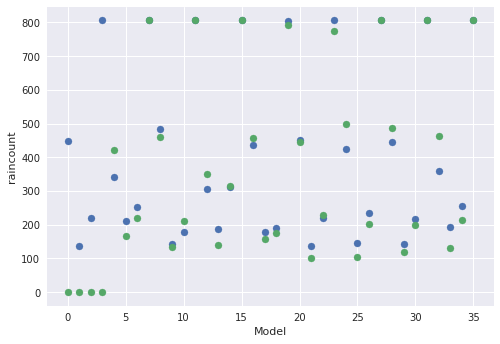

In [38]:
# Pseudo bar graph (to get initial sense of the data)
plt.scatter(range(len(hist_counts)),hist_counts)
plt.scatter(range(len(rcp85_counts)),rcp85_counts)
plt.xlabel('Model')
plt.ylabel('raincount');

In [39]:
plt.style.use('seaborn')
hist_counts2 = []
rcp85_counts2 = []
stride = len(hist_counts)//4 
for ii in range(0, len(hist_counts), 4):
    print(ii)
    hist_counts2.append([hist_counts[ii+jj] for jj in range(4)])
    rcp85_counts2.append([rcp85_counts[ii+jj] for jj in range(4)])
hist_counts2 = np.array(hist_counts2).T
rcp85_counts2 = np.array(rcp85_counts2).T

0
4
8
12
16
20
24
28
32


In [47]:
len(hist_counts2[0]), len(rcp85_counts2[0]), rcp85_counts2[0]   # Dry value for rcp85 models


(9, 9, array([  0, 421, 460, 350, 456, 446, 500, 487, 462]))

([<matplotlib.axis.XTick at 0x2b5b5400a040>,
 [Text(0, 0, 'obs'),
  Text(1, 0, 'raw'),
  Text(2, 0, 'RegCM4'),
  Text(3, 0, 'WRF'),
  Text(4, 0, 'CNN'),
  Text(5, 0, 'SDSM'),
  Text(6, 0, 'KDDM'),
  Text(7, 0, 'MBCn'),
  Text(8, 0, 'LOCA')])

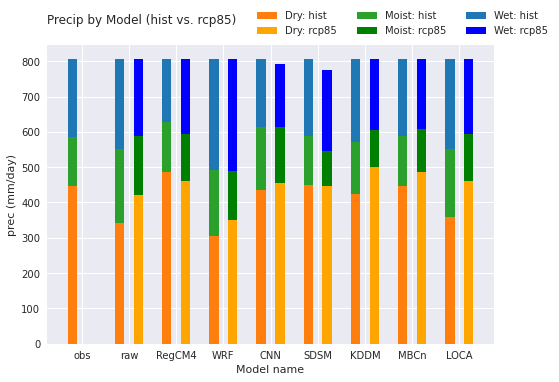

In [48]:
# Plot stacked bar graphs

names = ['obs','raw','RegCM4','WRF','CNN','SDSM','KDDM','MBCn','LOCA']

fields = ['Dry','Moist','Wet']
colors = ['orange', 'green', 'blue'] #, '#FAC748']
labels = ['Dry: hist', 'Dry: rcp85','Moist: hist', 'Moist: rcp85', 'Wet: hist', 'Wet: rcp85']


# plot bars
bottom_hist = len(hist_counts2[0]) * [0]
bottom_rcp85 = len(rcp85_counts2[0]) * [0]
mn = len(hist_counts2[0])
xc = range(mn)
xf = [xx+.2 for xx in xc]
xh = [xx-.2 for xx in xc]

for idx, name in enumerate(fields):
    plt.bar(xh, hist_counts2[idx], width=.2, bottom = bottom_hist, color='tab:'+colors[idx])
    plt.bar(xf, rcp85_counts2[idx], width=.2, bottom = bottom_rcp85, color=colors[idx])
    bottom_hist = bottom_hist + hist_counts2[idx]
    bottom_rcp85 = bottom_rcp85 + rcp85_counts2[idx]
    
# title, legend, labels
plt.title('Precip by Model (hist vs. rcp85)\n', loc='left')
#plt.legend(labels, bbox_to_anchor=([0.55, 1, 0, 0]), ncol=4, frameon=False)
plt.legend(labels, bbox_to_anchor=([0.45, 1, 0, 0]), ncol = 3)
plt.xlabel('Model name')
plt.ylabel('prec (mm/day)')

plt.xticks(xc, names)


# Unstacked bar charts

### Historical

In [49]:
hist_counts2[0], hist_counts2.shape

(array([448, 342, 485, 305, 436, 450, 425, 446, 358]), (4, 9))

([<matplotlib.axis.XTick at 0x2b5b529ccc70>,
 [Text(0, 0, 'obs'),
  Text(1, 0, 'raw'),
  Text(2, 0, 'RegCM4'),
  Text(3, 0, 'WRF'),
  Text(4, 0, 'CNN'),
  Text(5, 0, 'SDSM'),
  Text(6, 0, 'KDDM'),
  Text(7, 0, 'MBCn'),
  Text(8, 0, 'LOCA')])

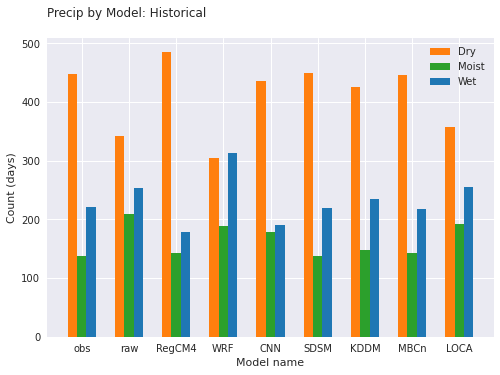

In [50]:
# Hist
labels = ['Dry', 'Moist', 'Wet']


nm = len(hist_counts2[0])
xc = range(mn)
xd = [xx-.2 for xx in xc]
xm = [xx for xx in xc]
xw = [xx+.2 for xx in xc]

xf = range(nm)
plt.bar(xd, hist_counts2[0], width=.2, color='tab:orange')
plt.bar(xm, hist_counts2[1], width=.2, color='tab:green')
plt.bar(xw, hist_counts2[2], width=.2, color='tab:blue')

# title, legend, labels
plt.title('Precip by Model: Historical\n', loc='left')
#plt.legend(labels, bbox_to_anchor=([0.55, 1, 0, 0]), ncol=4, frameon=False)
plt.legend(labels)
plt.xlabel('Model name')
#plt.ylabel('prec (mm/day)')
plt.ylabel('Count (days)')


plt.xticks(xc, names)


### Rcp85

([<matplotlib.axis.XTick at 0x2b5b52b131f0>,
 [Text(0, 0, 'obs'),
  Text(1, 0, 'raw'),
  Text(2, 0, 'RegCM4'),
  Text(3, 0, 'WRF'),
  Text(4, 0, 'CNN'),
  Text(5, 0, 'SDSM'),
  Text(6, 0, 'KDDM'),
  Text(7, 0, 'MBCn'),
  Text(8, 0, 'LOCA')])

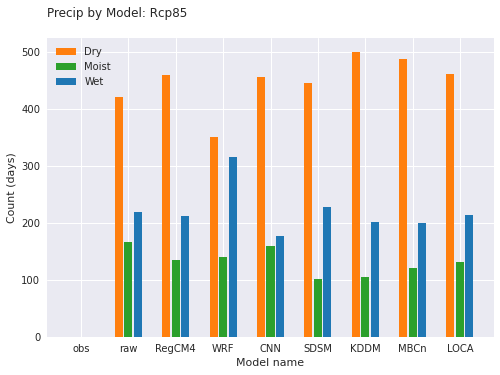

In [51]:
# Rcp85
labels = ['Dry', 'Moist', 'Wet']


nm = len(rcp85_counts2[0])
xc = range(mn)
xd = [xx-.2 for xx in xc]
xm = [xx for xx in xc]
xw = [xx+.2 for xx in xc]

xf = range(nm)
plt.bar(xd, rcp85_counts2[0], width=.17, color='tab:orange')
plt.bar(xm, rcp85_counts2[1], width=.17, color='tab:green')
plt.bar(xw, rcp85_counts2[2], width=.17, color='tab:blue')

# title, legend, labels
plt.title('Precip by Model: Rcp85\n', loc='left')
#plt.legend(labels, bbox_to_anchor=([0.55, 1, 0, 0]), ncol=4, frameon=False)
plt.legend(labels)
plt.xlabel('Model name')
plt.ylabel('Count (days)')

plt.xticks(xc, names)


# Unstacked bar charts part2

### Historical vs Rcp85

In [52]:
hist_counts2[0], hist_counts2.shape

(array([448, 342, 485, 305, 436, 450, 425, 446, 358]), (4, 9))

In [53]:
hist_counts2[0:3].max(), rcp85_counts2[0:3].max()

(485, 500)

In [54]:
max_y = max(hist_counts2[0:3].max(), rcp85_counts2[0:3].max())
max_y

500

([<matplotlib.axis.XTick at 0x2b5b524d57c0>,
 [Text(0, 0, 'obs'),
  Text(1, 0, 'raw'),
  Text(2, 0, 'RegCM4'),
  Text(3, 0, 'WRF'),
  Text(4, 0, 'CNN'),
  Text(5, 0, 'SDSM'),
  Text(6, 0, 'KDDM'),
  Text(7, 0, 'MBCn'),
  Text(8, 0, 'LOCA')])

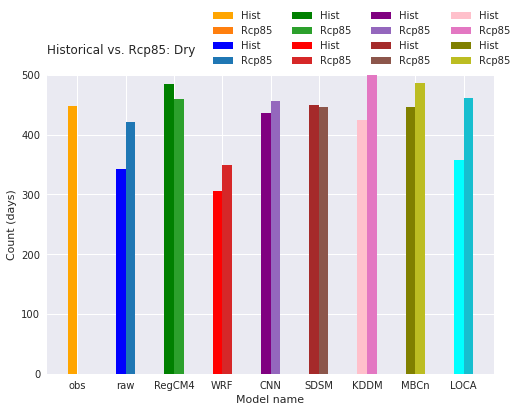

In [55]:
# Dry
labels = ['Hist','Rcp85']*8
#labels = {'orange':'hist','blue':'hist','green':'hist','red':'hist','purple':'hist','brown':'hist','pink':'hist','olive':'hist','cyan':'hist'}

colors = ['orange','blue','green','red','purple','brown','pink','olive','cyan']
colors2 = ['tab:'+cc for cc in colors]

nm = len(rcp85_counts2[0])
xc = range(mn)
xd = [xx-.1 for xx in xc]
xm = [xx for xx in xc]
xw = [xx+.1 for xx in xc]

xf = range(nm)
for ii in range(nm):
    plt.bar(xd[ii], hist_counts2[0][ii], width=.2, color=colors[ii])
    plt.bar(xw[ii], rcp85_counts2[0][ii], width=.2, color=colors2[ii])

# title, legend, labels
#plt.title('Historical vs. Rcp85: Dry\n', loc='center')
plt.title('Historical vs. Rcp85: Dry\n', loc='left')
#plt.legend(labels, bbox_to_anchor=([0.55, 1, 0, 0]), ncol=4, frameon=False)
plt.xlabel('Model name')
plt.ylabel('Count (days)')
plt.ylim([0, max_y])

#plt.legend(labels, bbox_to_anchor=([0.45, 1, 0, 0]), ncol = 2)
#plt.legend(labels)
#plt.legend(labels, bbox_to_anchor=([0.45, 1, 0, 0]), ncol = 3)
#plt.legend(labels)
plt.legend(labels, bbox_to_anchor=([0.35, 1, 0, 0]), ncol = 4)


plt.xticks(xc, names)

([<matplotlib.axis.XTick at 0x2b5b525c2d30>,
 [Text(0, 0, 'obs'),
  Text(1, 0, 'raw'),
  Text(2, 0, 'RegCM4'),
  Text(3, 0, 'WRF'),
  Text(4, 0, 'CNN'),
  Text(5, 0, 'SDSM'),
  Text(6, 0, 'KDDM'),
  Text(7, 0, 'MBCn'),
  Text(8, 0, 'LOCA')])

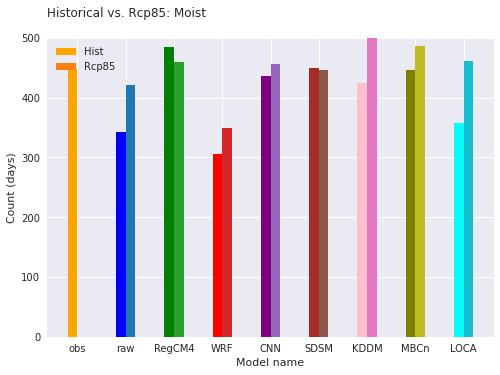

In [56]:
# Moist
labels = ['Hist', 'Rcp85']

nm = len(rcp85_counts2[0])
xc = range(mn)
xd = [xx-.1 for xx in xc]
xm = [xx for xx in xc]
xw = [xx+.1 for xx in xc]

xf = range(nm)
plt.bar(xd, hist_counts2[0], width=.2, color=colors)
plt.bar(xw, rcp85_counts2[0], width=.2, color=colors2)

# title, legend, labels
#plt.title('Historical vs. Rcp85: Dry\n', loc='center')
plt.title('Historical vs. Rcp85: Moist\n', loc='left')
#plt.legend(labels, bbox_to_anchor=([0.55, 1, 0, 0]), ncol=4, frameon=False)
plt.xlabel('Model name')
plt.ylabel('Count (days)')
plt.ylim([0, max_y])

#plt.legend(labels, bbox_to_anchor=([0.45, 1, 0, 0]), ncol = 2)
plt.legend(labels)

plt.xticks(xc, names)

([<matplotlib.axis.XTick at 0x2b5b5400baf0>,
 [Text(0, 0, 'obs'),
  Text(1, 0, 'raw'),
  Text(2, 0, 'RegCM4'),
  Text(3, 0, 'WRF'),
  Text(4, 0, 'CNN'),
  Text(5, 0, 'SDSM'),
  Text(6, 0, 'KDDM'),
  Text(7, 0, 'MBCn'),
  Text(8, 0, 'LOCA')])

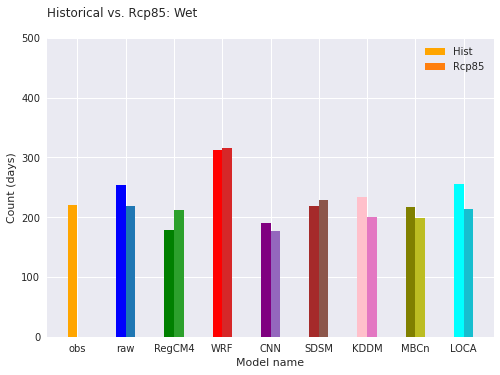

In [57]:
# Wet
labels = ['Hist', 'Rcp85']

nm = len(rcp85_counts2[0])
xc = range(mn)
xd = [xx-.1 for xx in xc]
xm = [xx for xx in xc]
xw = [xx+.1 for xx in xc]

xf = range(nm)
plt.bar(xd, hist_counts2[2], width=.2, color=colors)
plt.bar(xw, rcp85_counts2[2], width=.2, color=colors2)
#plt.bar(xw, hist_counts2[2], width=.2, color='tab:blue')

# title, legend, labels
#plt.title('Historical vs. Rcp85: Dry\n', loc='center')
plt.title('Historical vs. Rcp85: Wet\n', loc='left')
#plt.legend(labels, bbox_to_anchor=([0.55, 1, 0, 0]), ncol=4, frameon=False)
plt.xlabel('Model name')
plt.ylabel('Count (days)')
plt.ylim([0, max_y])

#plt.legend(labels, bbox_to_anchor=([0.45, 1, 0, 0]), ncol = 2)
plt.legend(labels)

plt.xticks(xc, names)

#### Dry, Moist and Wet, togther

([<matplotlib.axis.XTick at 0x2b5b5409d7c0>,
 [Text(0, 0, 'obs'),
  Text(1, 0, 'raw'),
  Text(2, 0, 'RegCM4'),
  Text(3, 0, 'WRF'),
  Text(4, 0, 'CNN'),
  Text(5, 0, 'SDSM'),
  Text(6, 0, 'KDDM'),
  Text(7, 0, 'MBCn'),
  Text(8, 0, 'LOCA')])

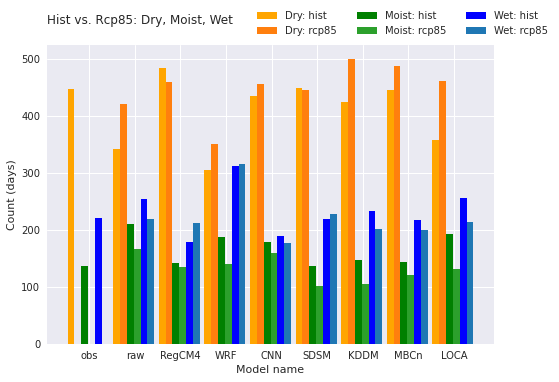

In [58]:
# Dry, Moist and Wet
#labels = ['Hist', 'Rcp85']
labels = ['Dry: hist', 'Dry: rcp85','Moist: hist', 'Moist: rcp85', 'Wet: hist', 'Wet: rcp85']


nm = len(rcp85_counts2[0])
xc = range(mn)
xd1 = [xx-.4 for xx in xc]
xd2 = [xx-.25 for xx in xc]

xm1 = [xx-.1 for xx in xc]
xm2 = [xx+.05 for xx in xc]


xw1 = [xx+.2 for xx in xc]
xw2 = [xx+.35 for xx in xc]

xf = range(nm)
plt.bar(xd1, hist_counts2[0], width=.15, color='orange')
plt.bar(xd2, rcp85_counts2[0], width=.15, color='tab:orange')

plt.bar(xm1, hist_counts2[1], width=.15, color='green')
plt.bar(xm2, rcp85_counts2[1], width=.15, color='tab:green')

plt.bar(xw1, hist_counts2[2], width=.15, color='blue')
plt.bar(xw2, rcp85_counts2[2], width=.15, color='tab:blue')

# title, legend, labels
plt.title('Hist vs. Rcp85: Dry, Moist, Wet\n', loc='left')
plt.xlabel('Model name')
plt.ylabel('Count (days)')
plt.legend(labels, bbox_to_anchor=([0.45, 1, 0, 0]), ncol = 3)

plt.xticks(xc, names)